# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
import scippneutron as scn
from scippneutron.conversion import graph
import os
from IPython.display import Image
import h5py
import sys

## Data reduction process

Full overview of how converison is done: 

![conversion_tree](DataReductionToMjolnir.png)

### Getting information from BIFROST_McStas_backend_information.csv

In [2]:
back_info = pd.read_csv('../BIFROST_Design_Article/Energy_resolution/BIFROST_McStas_backend_information.csv')
#back_info = back_info.loc[back_info['wedge_number'] == 1]

back_info = np.asarray(back_info)[:,0:5]

for j in range(len(back_info)):
    back_info[j,3] = back_info[j,3].replace(',','.')
    back_info[j,4] = back_info[j,3].replace(',','.')

back_info = np.asarray(back_info, dtype=float)    
    
back_info = back_info[(back_info[:,0]== 2.7)  & (back_info[:,2]== 4) | (back_info[:,0]== 3.2) & (back_info[:,2]== 4)| (back_info[:,0]== 3.8) & (back_info[:,2]== 5) | (back_info[:,0]== 4.4) & (back_info[:,2]== 5) | (back_info[:,0]== 5.0) & (back_info[:,2]== 5)]


# Define the Tube Measurment object

This Object is designed to contain 1 tube mearsurment, in a given (A3, A4) setting,  including data and metadata needed for further reduction. To this object the following information can be assosiated:

**Should be defined from:** wedge, arc, tube

Data:
- I (y, t)
- I _err (y,t)

Axis:
- t_s
- y_m
- A4

Metadata:
- A3 (sample rotation)
- L_sd (length from detector to sample)
- Ef (The Ef for the given analyser)

In [7]:

class tube_measurement:
    def __init__(self,wedge=0, arc=0, tube=0, I=0, I_err=0, t_s = 0, y_m = 0, A4=0, A3=0, L_sd=0, Ef=0, Delta_E=0, Ei=0, dA4=0, Q=0):
        self.wedge = wedge
        self.arc = arc
        self.tube = tube
        self.I = I
        self.I_err = I_err
        self.t_s = t_s
        self.y_m = y_m
        self.A3 = A3
        self.A4 = A4
        self.Delta_E = Delta_E
        self.Ei = Ei
        self.dA4 = dA4
        self.Q = Q
        
        self.L_sd = L_sd
        self.Ef = Ef
    
        """ Get L_sd """
        arc_values = {0: 2.7,1: 3.2,2: 3.8,3: 4.4,4: 5.0}

        # Loop through each arc value
        for arc, value in arc_values.items():
            # Check if the current arc value matches self.arc
            if self.arc == arc:
                # Filter the corresponding row from back_info
                ar = back_info[back_info[:, 0] == value]
                
                # Determine wedge conditions and calculate self.L_sd accordingly
                if self.wedge in (0, 3, 6):
                    self.L_sd = ar[0, 3] + ar[0, 4]
                elif self.wedge in (1, 4, 7):
                    self.L_sd = ar[1, 3] + ar[1, 4]
                elif self.wedge in (2, 5, 8):
                    self.L_sd = ar[2, 3] + ar[2, 4]
                break  # Exit the loop after finding the matching arc value

        """ Get Ef (Think about making the Ef correction based on the dA4 takeoff angle) """
        if arc == 0:
            self.Ef = 2.7
        if arc == 1:
            self.Ef = 3.2
        if arc == 2:
            self.Ef = 3.8
        if arc == 3:
            self.Ef = 4.4
        if arc == 4:
            self.Ef = 5.0

            
    def getI(self, filename):
        """
        Loading the data from the 
        """
        with h5py.File(filename, 'r') as file:
            self.I = file['entry1/data/signal_1Dspace_'+str(self.wedge)+'_'+str(self.arc)+'_'+str(self.tube)+'_dat/data'][()].astype('float')
        return self.I
    
    def getI_err(self, filename):
        with h5py.File(filename, 'r') as file:
            self.I_err = file['entry1/data/signal_1Dspace_'+str(self.wedge)+'_'+str(self.arc)+'_'+str(self.tube)+'_dat/errors'][()].astype('float')
        return self.I_err
    
    def get_t_s(self, filename):
        with h5py.File(filename, 'r') as file:
            self.t_s = file['entry1/data/signal_1Dspace_'+str(self.wedge)+'_'+str(self.arc)+'_'+str(self.tube)+'_dat/t__s_'][()]
        return self.t_s
    
    def get_y_m(self, filename):
        with h5py.File(filename, 'r') as file:
            self.y_m = file['entry1/data/signal_1Dspace_'+str(self.wedge)+'_'+str(self.arc)+'_'+str(self.tube)+'_dat/y__m_'][()]
        return self.y_m
    
    def getA3(self, filename): # Husk at finde rigtig index til A3
        with h5py.File(filename, 'r') as file:
            A3 = file['entry1/simulation/Param/A3'][()].astype('int64')[0]
            self.A3 = A3
        return self.A3
    
    def getA4(self, filename):
        
        # Get the angular offset from direct beam to first wedge
        with h5py.File(filename, 'r') as file:
            A4_offset = file['entry1/simulation/Param/A4'][()].astype('int64')[0]
            A4_offset = A4_offset

        # Get the angular offset from wedge number
        wedge_offsets = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80])
        wedge_offset = wedge_offsets[self.wedge]
            
        # Calculate the A4 degrees for each pixel on tube
        self.dA4 = np.degrees(np.arctan((self.y_m/self.L_sd)))
        
        # Add the offset for tank and wedge number
        self.A4 = A4_offset + wedge_offset + self.dA4

        return self.A4, self.dA4

    def calcDE(self):
        
        # Make correction to each physicals bins Ef (At this step self.Ef has shape (100,))
        ideal_lam = 1/(0.11056*np.sqrt(self.Ef))
        self.Ef = (9.045/(ideal_lam*np.cos(np.radians(self.dA4))))**2

        # Define constants
        t = self.t_s # time measured in [s] has shape (N time bins)
        Ef_J = self.Ef*1.602176634e-22 # [J]
        Li = 162 # [m]
        m_n = 1.67492749804e-27 # [kg]

        # calculate Delta E for all points I
        T, D = np.meshgrid(t, Ef_J)
        self.Ei = (Li**2*m_n)/(2*(T-np.sqrt((m_n*self.L_sd**2)/(2*D)))**2)
        self.Delta_E = (self.Ei-D)*6.24150907e21 # convert from J to meV
        
        self.Ei = self.Ei*6.24150907e21 # convert from J to meV

        # Make Ef the right shape to have Ef for each I datapoint
        self.Ef = self.Ef.reshape(-1,1) 
        self.Ef = np.tile(self.Ef, (1,len(t)))

        return self.Delta_E, self.Ef, self.Ei # has shape (y_m=100, N time bins)
    

    def calcQ(self):

        lam_i = 1/(0.11056*np.sqrt(self.Ei))
        ki = (2*np.pi)/lam_i
        #print('Shape of ki =', np.shape(ki))
        
        # Calc kf
        lam_f = 1/(0.11056*np.sqrt(self.Ef))
        kf =  ((2*np.pi)/lam_f)
        #print('Shape of kf =',np.shape(kf))

        # Reshape A4 to have A4 for each matrix
        A4 = self.A4.reshape(-1,1)
        A4 = np.tile(A4, (1,len(ki[0,:])))
    
        # Calc qx and qy       
        qx = ki-kf*np.cos(np.radians(A4))
        qy = kf*np.sin(np.radians(A4))

        self.Q = np.stack((qx,qy))

        return self.Q



## Importing all tubes for a given A3, A4 setting.

In [4]:

def load_Backend_measurment(filepath):
    """
    
    """
    setting = {}
    
    for w in range(9):
        for t in range(3):
            obj = tube_measurement(wedge=w, arc=4, tube=t)

            obj.getI(filepath)
            obj.getI_err(filepath)

            obj.get_t_s(filepath)
            obj.get_y_m(filepath)
            obj.getA4(filepath)

            obj.getA3(filepath)
            obj.calcDE()
            obj.calcQ()
            setting['TM_'+str(w)+'_4_'+str(t)] = obj
    
    return setting


settings = load_Backend_measurment('../McStasScript/run_folder/test3/mccode.hdf5')

print('Estimated memory size of a Backend measurment =',sys.getsizeof(settings)/1024, 'kB')



Estimated memory size of a Backend measurment = 1.1484375 kB


## Exporting dataformat for MJOLNIR

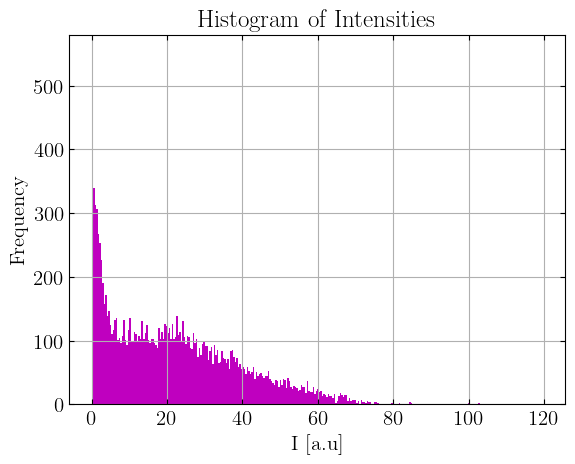

In [5]:
data_flat = ob.I.flatten()

# Create a histogram
plt.hist(data_flat[(data_flat>0.1)], bins=300, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

## Organizing datastructure in scipp 

Datastructure includes lab information

In [6]:
scipp_dict = {}
for i in range(2):
    key = f'A3 setting{i}'
    value = sc.array(dims=['tube', 'y', 't'], values=data[0], variances=data[1])
    scipp_dict[key] = value

print(scipp_dict)

NameError: name 'data' is not defined

In [ ]:
sim_data = sc.Dataset(
    data=scipp_dict, # sc.array(dims=['y', 't', 'tube'], values=I_A3),
    coords={
        'y': sc.array(dims=['y'], values=data[2], unit='m'),
        't': sc.array(dims=['t'], values=data[3], unit='s'),
        'L_sd': sc.array(dims=['tube'], values=np.arange(27.0)),
        'Ana': sc.array(dims=['tube'], values=np.ones(27)*5),
        'wedge': sc.array(dims=['tube'], values=np.arange(27.0)),
    },
)

sc.show(sim_data)
sim_data

# Constructing the data reduction tree

In [ ]:
def backscattered_l2(position, sample_position, analyzer_position):
    """
    Compute the length of the secondary flight path for backscattering off an analyzer.
    """
    return sc.norm(position - analyzer_position) + sc.norm(
        analyzer_position - sample_position
    )


def wavelength_from_analyzer(analyzer_dspacing, analyzer_angle):
    """
    Compute the neutron wavelength after scattering from the analyzer's d-spacing.

    Assuming Bragg scattering in the analyzer, the wavelength is
        wavelength = 2 * d * sin(theta)

    Where
        d is the analyzer's d-spacing,
        theta is the scattering angle or equivalently, the tilt of the analyzer
              w.r.t. to the sample-analyzer axis.
    """
    # 2*theta is the angle between transmitted and scattered beam.
    return (
        2
        * analyzer_dspacing
        * sc.sin(sc.scalar(np.pi / 2, unit="rad") - analyzer_angle.to(unit="rad"))
    )

In [ ]:
from scippneutron.conversion.graph.beamline import beamline
from scippneutron.conversion.tof import energy_transfer_indirect_from_tof

graph = {
    **beamline(scatter=True),
    "energy_transfer": energy_transfer_indirect_from_tof,
    # Replace L2 with our own implementation.
    "L2": backscattered_l2,
    # Insert a new function for the wavelength.
    "final_wavelength": wavelength_from_analyzer,
}
# Optional: remove unused functions in order to clean up the image below.
del graph["two_theta"]
del graph["scattered_beam"]
del graph["Ltotal"]
#sc.show_graph(graph, simplified=True)